In [1]:
# import torch
# import random
import numpy as np

# torch.manual_seed(1337)
# torch.cuda.manual_seed(1337)
# np.random.seed(1337)
# random.seed(1337)

import os
from run import Run
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KDTree
import cv2
from copy import deepcopy

In [68]:
class Visualizer:
    def __init__(self, datapath=None):
        self.datapath = datapath
        self.ids = [self.get_id(f) for f in os.listdir(self.datapath) if "rgb_" in f]
    def get_id(self, fname):
        return fname.split('_')[1].replace(".png", "")    

    def outer_inner_corresp(self, i=None):
        depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
#         variance = np.load(os.path.join(self.datapath, "%s_variance.npy" % i))
        green = Image.open(os.path.join(self.datapath, "%s_labels_green.png" % i))
        yellow = Image.open(os.path.join(self.datapath, "%s_labels_yellow.png" % i))
        red = Image.open(os.path.join(self.datapath, "%s_labels_red.png" % i))
        seg = np.stack([red, yellow, green], axis=-1)
        im_height, im_width, _ = seg.shape
        
        # Set regions of overlapping masks to 0
        seg[np.logical_and(seg[:,:,1]==255, seg[:,:,2]==255),2] = 0
        seg[np.logical_and(seg[:,:,1]==255, seg[:,:,2]==255),1] = 0
        
        # Get outer-inner edge correspondence
        xx, yy =  np.meshgrid([x for x in range(im_width)],
                              [y for y in range(im_height)])
        xx_o = xx[seg[:,:,1]==255]
        yy_o = yy[seg[:,:,1]==255]

        inner_edges_mask = np.ones((im_height, im_width))
        inner_edges_mask[seg[:,:,2]==255] = 0
        dists, lbl = cv2.distanceTransformWithLabels(inner_edges_mask.astype(np.uint8), cv2.DIST_L2, 
                                                     5, labelType=cv2.DIST_LABEL_PIXEL)

        # lbl provides at each pixel the index label of        val_sum_path = os.path.join(self.model_path, "summaries", "val", self.run_id) the closest zero point. 
        # Now we find the pixel coordinate of that index label
        inner_pxs = np.where(inner_edges_mask==0)
        xx_inner = inner_pxs[1] # x coords of inner edges
        yy_inner = inner_pxs[0] # y coords of inner edges
        labels_to_pxs = [[0, 0]] # fix off by one offset
        for j in range(len(yy_inner)):
            labels_to_pxs.append([yy_inner[j],xx_inner[j]])
        labels_to_pxs = np.array(labels_to_pxs)
        closest_inner_px = labels_to_pxs[lbl]
        
        # Visualize a fraction of the correspondences as arrows
#         factor = 20
#         plt.figure(dpi=150)
#         plt.imshow(seg)
#         plt.quiver(xx_o[::factor], yy_o[::factor], 
#                    closest_inner_px[yy_o[::factor], xx_o[::factor]][:,1]-xx_o[::factor], 
#                    -closest_inner_px[yy_o[::factor], xx_o[::factor]][:,0]+yy_o[::factor], 
#                    color='orange', scale_units='xy', scale=1.0)
        
        # Calculate distance to the closest inner edge point for every pixel in the image
        dist_to_inner = np.zeros(closest_inner_px.shape)
        dist_to_inner[:,:,0] = np.abs(closest_inner_px[:,:,0]-yy)
        dist_to_inner[:,:,1] = np.abs(closest_inner_px[:,:,1]-xx)
        
        # Normalize distance vectors
        mag = np.linalg.norm([dist_to_inner[:,:,0],dist_to_inner[:,:,1]],axis = 0)+0.00001
        dist_to_inner[:,:,0] = dist_to_inner[:,:,0]/mag
        dist_to_inner[:,:,1] = dist_to_inner[:,:,1]/mag

        # For every outer edge point, find its closest K neighbours 
        num_neighbour = 100
        outer_idxs = np.vstack([xx_o,yy_o])
        try:
            tree = KDTree(outer_idxs.T, leaf_size=2)
        except Exception as e:
            return 0, 0, 0, 0, 0, None, None, None
        if num_neighbour > xx_o.shape[0]:
            return 0, 0, 0, 0, 0, None, None, None
        dist, ind = tree.query(outer_idxs.T, k=num_neighbour)
        
        dist_to_inner_o = dist_to_inner[seg[:,:,1]==255,:]
        xx_neighbours = dist_to_inner_o[ind][:,:,1]
        yy_neighbours = dist_to_inner_o[ind][:,:,0]
        xx_var = np.var(xx_neighbours,axis = 1)
        yy_var = np.var(yy_neighbours,axis = 1)
        var = xx_var+yy_var
        var = var / var.max()
#         var = (var - var.min()) / (var.max() - var.min())
        var_map = np.zeros((im_height, im_width))
        for i in range(xx_o.shape[0]): # xx_o is flat
            var_map[yy_o[i]][xx_o[i]] = var[i]
        
        invvar = 1.0 - var # get inverse
#         pvar = invvar / np.sum(invvar)
        pvar = invvar
        pvar_map = np.zeros((im_height, im_width))
        for i in range(xx_o.shape[0]): # xx_o is flat
            pvar_map[yy_o[i]][xx_o[i]] = pvar[i]
        
        plt.figure()
        plt.subplots_adjust(top=1.5, right=1.5)
        plt.subplot(121)
        plt.imshow(var_map, vmin=var_map.min(), vmax=var_map.max())
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("New var: %0.5f %0.5f" % (var_map.min(), var_map.max()))
        
        plt.subplot(122)
#         plt.imshow(pvar_map, vmin=0.0, vmax=1.0)
        plt.imshow(pvar_map, vmin=pvar_map.min(), vmax=pvar_map.max())
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("New inv var: %0.5f %0.5f" % (pvar_map.min(), pvar_map.max()))
        plt.show()
        
#         np.save("/home/jianingq/Downloads/newvar.npy", pvar_map)

    def sample_dataset(self):
        for i in [1, 10, 100]:
            rgb = Image.open(os.path.join(self.datapath, "rgb_%s.png" % i))
            depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
            max_d = np.nanmax(depth)
            depth[np.isnan(depth)] = max_d
            
            gt_map = np.load(os.path.join(self.datapath, "%s_inverse_variance.npy" % i))
            
            plt.imshow(rgb)
            plt.show()
            plt.imshow(depth)
            plt.show()
            plt.imshow(gt_map)
            plt.show()

    def seg_output(self, i=None, model=None):
        rgb = Image.open(os.path.join(self.datapath, "rgb_%s.png" % i))
        depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
        max_d = np.nanmax(depth)
        depth[np.isnan(depth)] = max_d
        
        green = Image.open(os.path.join(self.datapath, "%s_labels_green.png" % i))
        yellow = Image.open(os.path.join(self.datapath, "%s_labels_yellow.png" % i))
        red = Image.open(os.path.join(self.datapath, "%s_labels_red.png" % i))
        
        im_gt = np.stack([red, yellow, green], axis=-1)

        yellow_npy = np.asarray(yellow)
        mask = np.zeros_like(yellow_npy, dtype=np.float32)
        mask[yellow_npy > 254] = 1.0
        
#         if model == None: return
        out = model.evaluate(depth).squeeze()
        seg_pred = out[:, :, :3]
        
#         prob_pred *= mask
        seg_pred_th = deepcopy(seg_pred)
        seg_pred_th[seg_pred_th < 0.8] = 0.0
        
        plt.figure(dpi=300)
        plt.subplot(141)
        plt.title("rgb")
        plt.imshow(rgb)
        plt.axis("off")
        plt.subplot(142)
        plt.title("gt seg")
        plt.imshow(im_gt)
        plt.axis("off")
        plt.subplot(143)
        plt.title("model raw")
        plt.axis("off")
        plt.imshow(seg_pred)
        plt.subplot(144)
        plt.title("model thresh")
        plt.imshow(seg_pred_th)
#         plt.tight_layout()
        plt.axis("off")
        plt.show()
        
    def var_output(self, i=None, model=None):
        rgb = Image.open(os.path.join(self.datapath, "rgb_%d.png" % i))
        depth = np.load(os.path.join(self.datapath, "%d_depth.npy" % i))
        max_d = np.nanmax(depth)
        depth[np.isnan(depth)] = max_d
        
        yellow = Image.open(os.path.join(self.datapath, "%d_labels_yellow.png" % i))
        yellow_npy = np.asarray(yellow)
        mask = np.zeros_like(yellow_npy, dtype=np.float32)
        mask[yellow_npy > 254] = 1.0
        
#         print(os.path.join(self.datapath, "%s_inverse_variance.npy" % i))
        gt_map = np.load(os.path.join(self.datapath, "%d_inverse_variance.npy" % i)).astype(np.float32)
        gt_map[yellow_npy < 255] = 0.0
        print(os.path.join(self.datapath, "%d_inverse_variance.npy" % i))
        
        var_pred = model.evaluate(depth).squeeze()
        var_pred_masked = deepcopy(var_pred)
        var_pred_masked *= mask
        
        plt.figure(dpi=300)
        plt.subplot(141)
        plt.title("rgb")
        plt.imshow(rgb)
        plt.axis("off")
        plt.subplot(142)
        plt.title("gt invvar")
#         plt.imshow(gt_map, vmin=0.0, vmax=1.0)
        plt.imshow(gt_map)
#         plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")
        plt.subplot(143)
        plt.title("model raw")
        plt.axis("off")
        plt.imshow(var_pred, vmin=0.0, vmax=1.0)
#         plt.colorbar()
        plt.subplot(144)
        plt.title("model masked")
        plt.imshow(var_pred_masked, vmin=0.0, vmax=1.0)
        plt.colorbar(fraction=0.046, pad=0.04)
#         plt.tight_layout()
        plt.axis("off")
        plt.show()

/home/jianingq/data_studio_painted_towel_r0.1/camera_3/0_inverse_variance.npy


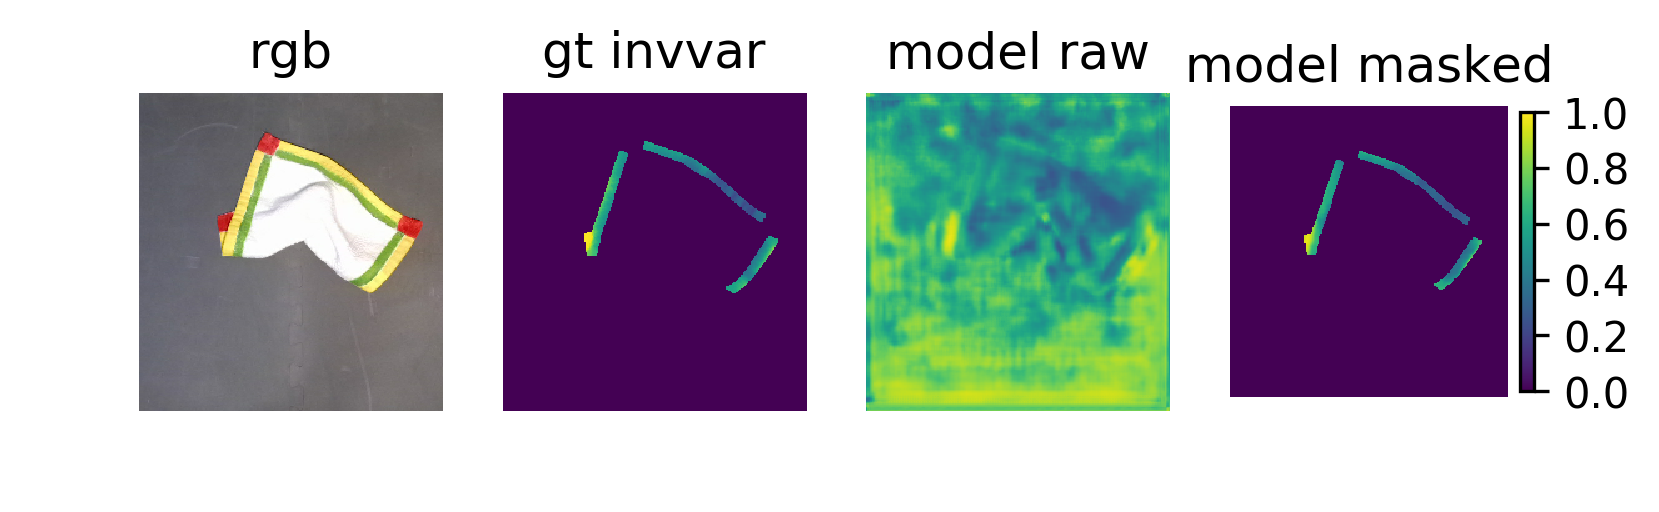

In [80]:
# model_id = 31
# epoch = 120
# # pretrained_model = "/media/ExtraDrive2/jianingq/train_runs/dbg/%d/chkpnts/dbg%d_epoch%d" % (model_id, model_id, epoch)
# pretrained_model = "/media/ExtraDrive2/jianingq/train_runs/%d/chkpnts/%d_epoch%d" % (model_id, model_id, epoch)
# # pretrained_model = "/media/ExtraDrive2/jianingq/models_towel/dbg2_epoch_240"
# datapath = "/home/jianingq/data_8singleim/camera_3"
# t = Run(model_path=pretrained_model, n_features=3)
# v = Visualizer(datapath)
# v.seg_output(i=0, model=t)

model_id = 130
epoch = 240
pretrained_model = "/media/ExtraDrive2/jianingq/train_runs/%d/chkpnts/%d_epoch%d" % (model_id, model_id, epoch)
datapath = "/home/jianingq/data_studio_painted_towel_r0.1/camera_3"
t1 = Run(model_path=pretrained_model, n_features=1)
v1 = Visualizer(datapath)
v1.var_output(i=0, model=t1)
# v1.sample_dataset()